In [0]:
import sys
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
#df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)  #> (2361, 3)
df['content'].head(10)

(11314, 3)


0        From: lerxst@wam.umd.edu (where's my thing)\nS...
1        From: guykuo@carson.u.washington.edu (Guy Kuo)...
10       From: irwin@cmptrc.lonestar.org (Irwin Arnstei...
100      From: tchen@magnus.acs.ohio-state.edu (Tsung-K...
1000     From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...
10000    From: a207706@moe.dseg.ti.com (Robert Loper)\n...
10001    From: kimman@magnus.acs.ohio-state.edu (Kim Ri...
10002    From: kwilson@casbah.acns.nwu.edu (Kirtley Wil...
10003    Subject: Re: Don't more innocents die without ...
10004    From: livesey@solntze.wpd.sgi.com (Jon Livesey...
Name: content, dtype: object

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

3. Tokenize Sentences and Clean
Removing the emails, new line characters, single quotes



In [0]:

def sent_to_words(sentences):
  print(sentences)
  
  for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

#Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


4.  lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.




In [0]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!



11314

5. Build the Topic Model


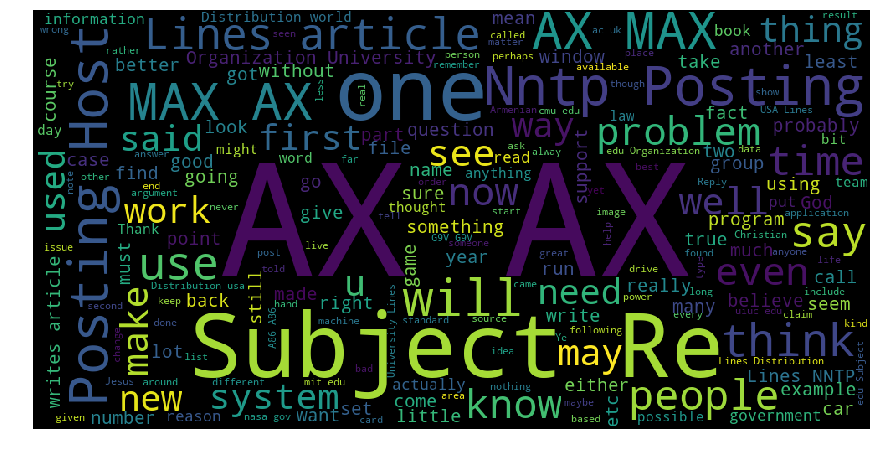

In [0]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#convert list to string and generate
unique_string=(" ").join(data)
wordcloud = WordCloud(width = 1000, height = 500 , stopwords = STOPWORDS).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [0]:

# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= 20)

pprint(lda_model.print_topics())

[(0,
  '0.009*"organization" + 0.008*"write" + 0.006*"article" + 0.006*"post" + '
  '0.005*"time" + 0.004*"university" + 0.004*"host" + 0.004*"nntp" + '
  '0.004*"day" + 0.003*"world"'),
 (1,
  '0.017*"file" + 0.010*"program" + 0.009*"window" + 0.007*"server" + '
  '0.006*"include" + 0.006*"write" + 0.005*"font" + 0.005*"set" + '
  '0.005*"version" + 0.005*"available"'),
 (2,
  '0.010*"write" + 0.008*"organization" + 0.008*"time" + 0.006*"article" + '
  '0.006*"post" + 0.004*"read" + 0.004*"university" + 0.004*"look" + '
  '0.003*"way" + 0.003*"host"'),
 (3,
  '0.034*"key" + 0.012*"chip" + 0.009*"clipper" + 0.008*"encryption" + '
  '0.008*"escrow" + 0.006*"organization" + 0.006*"bit" + 0.005*"post" + '
  '0.005*"algorithm" + 0.005*"encrypt"'),
 (4,
  '0.789*"ax" + 0.057*"max" + 0.004*"tm" + 0.004*"bhj" + 0.003*"giz" + '
  '0.003*"qax" + 0.001*"gq" + 0.001*"nrhj" + 0.001*"biz" + 0.001*"mg"'),
 (5,
  '0.017*"armenian" + 0.008*"turkish" + 0.006*"write" + 0.006*"people" + '
  '0.005*"artic

6.  Dominant topic and its percentage contribution in each document


In [0]:

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)








,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,14.0,0.5331,"leave, apartment, sumgait, mouse, organization...","[thing, car, nntp, post, host, rac, wam, umd, ..."
1,1,13.0,0.5760,"organization, card, write, post, system, artic...","[guy, clock, poll, final, call, summary, final..."
2,2,9.0,0.8266,"organization, wire, image, write, post, scsi, ...","[irwin, arnstein, recommendation, duc, summary..."
3,3,9.0,0.6645,"organization, wire, image, write, post, scsi, ...","[tsung, software, forsale, nntp, post, host, m..."
4,4,13.0,0.6169,"organization, card, write, post, system, artic...","[lindbergh, diamond, win, mouse, cursor, organ..."
5,5,6.0,0.6476,"car, organization, write, article, look, drive...","[robert, loper, sho, nntp, post, host, sun, ds..."
6,6,10.0,0.3456,"window, drive, organization, problem, disk, po...","[richard, man, syquest, cartrifge, forsale, ar..."
7,7,0.0,0.4827,"organization, write, article, post, time, univ...","[kirtley, wilson, mirosoft, office, package, a..."
8,8,8.0,0.5914,"write, article, people, organization, stephano...","[innocent, die, death, penalty, robert, beauch..."
9,9,15.0,0.3792,"people, god, write, christian, believe, organi...","[jon, livesey, genocide, cause, atheism, organ..."


7. The most representative sentence for each topic

In [0]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)



,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9959,"team, game, year, player, play, win, hockey, organization, write, league","[rocket, nhl, playoff, leader, april, organization, university, new, brunswick, distribution, re..."
1,1.0,0.9923,"server, widget, motif, msg, available, include, mit, organization, write, application","[larry, pyeatt, mix, xlib, nntp, post, host, organization, texaco, article, jay, graham, write, ..."
2,2.0,0.9945,"space, year, time, write, organization, article, first, point, orbit, power","[grinch, limit, govt, employment, concentrate, organization, grinchco, distribution, world, nntp..."
3,3.0,0.9893,"turkish, greek, armenian, turk, turkey, muslim, write, article, book, argic","[sabri, atan, turkey, cyprus, bosnia, serbia, greece, armenia, azeris, reply, sabri, atan, organ..."
4,4.0,0.9839,"people, armenian, president, write, government, system, question, law, mr, article","[fr, rice, ancient, islamic, ritual, organization, monash, university, melb, australia, benedikt..."
5,5.0,0.9998,"ax, max, tm, bhj, giz, qax, gq, nrhj, biz, mg","[roman, bmp, cliff, reply, cliff, distribution, usa, organization, university, south, dakota, pa..."
6,6.0,0.9922,"key, organization, bit, chip, available, number, system, datum, clipper, phone","[clayton, cramer, new, study, gay, percentage, organization, optilink, corporation, petaluma, ca..."
7,7.0,0.9893,"organization, write, article, post, water, host, nntp, point, polygon, university","[phil, fraer, japanese, moon, land, temporary, orbit, organization, univ, southwestern, louisian..."
8,8.0,0.9952,"window, file, organization, problem, system, write, work, post, host, program","[grubb, ide, scsi, organization, new, mexico, state, university, la, cruc, distribution, world, ..."
9,9.0,0.9827,"stephanopoulo, article, write, organization, bank, gordon, health, people, study, doctor","[gordon, bank, eugenic, reply, gordon, bank, organization, univ, pittsburgh, computer, science, ..."



8. Frequency Distribution of Word Counts in Documents







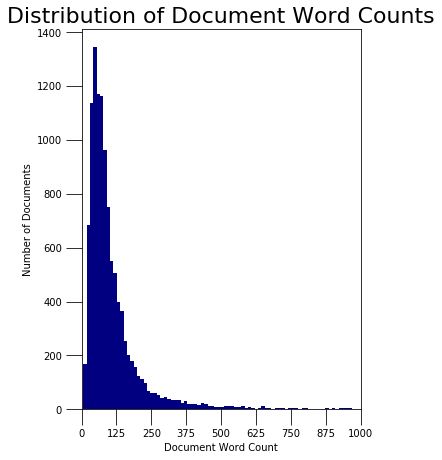

In [0]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,7))
plt.hist(doc_lens, bins = 1000, color='navy')


plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()




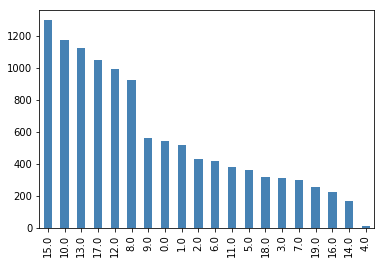

In [0]:
topics = []
for doc_bow in corpus:
    doc2topic_prob = lda_model.get_document_topics(doc_bow)
    doc2topic_prob= pd.DataFrame(doc2topic_prob,columns = ['topic','prob'])
    topic = doc2topic_prob.sort_values('prob',ascending=False).iloc[0]['topic']
    topics.append(topic)
data = pd.DataFrame()   
data['topics']=topics
data['topics'].value_counts().plot.bar(color='steelblue')

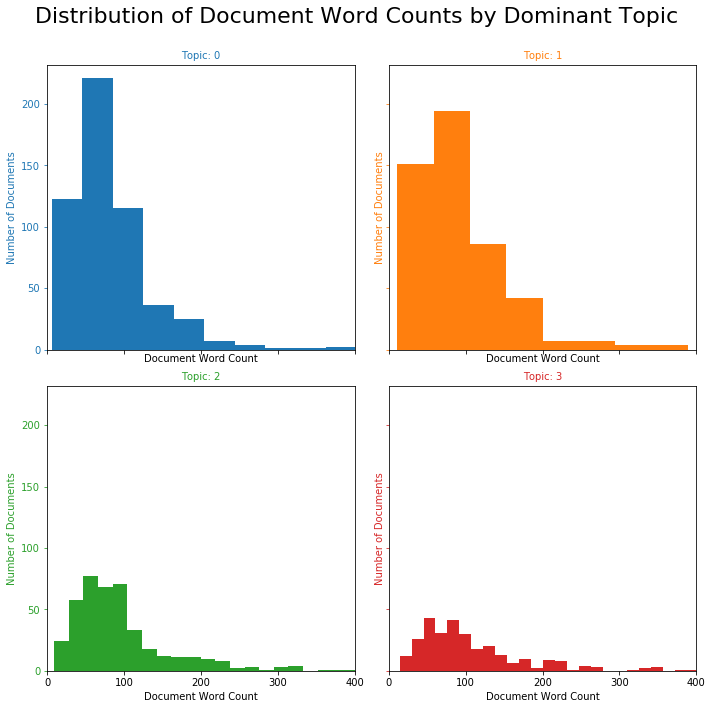

In [0]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(10,10),  sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    #sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 400), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=10, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,400,5))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

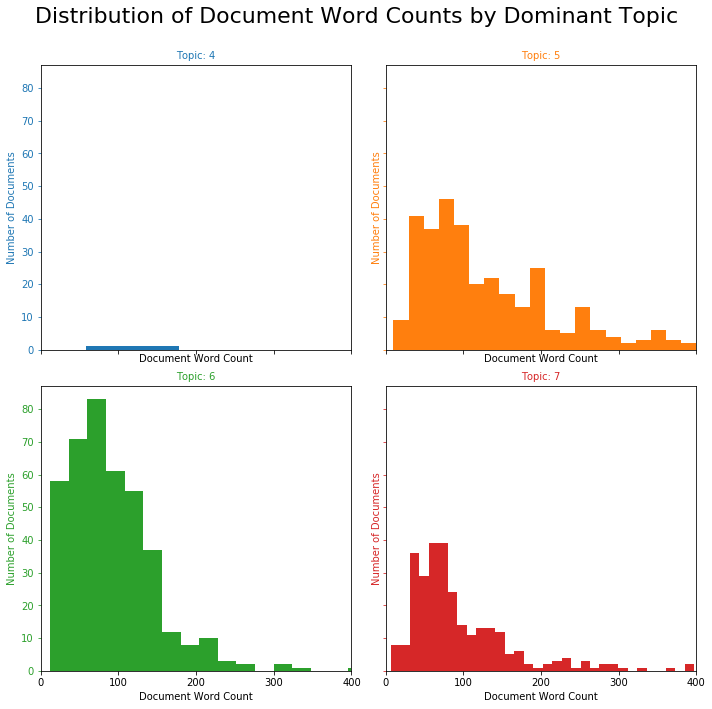

In [0]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(10,10),  sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i+4, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    #sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 400), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i+4), fontdict=dict(size=10, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,400,5))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

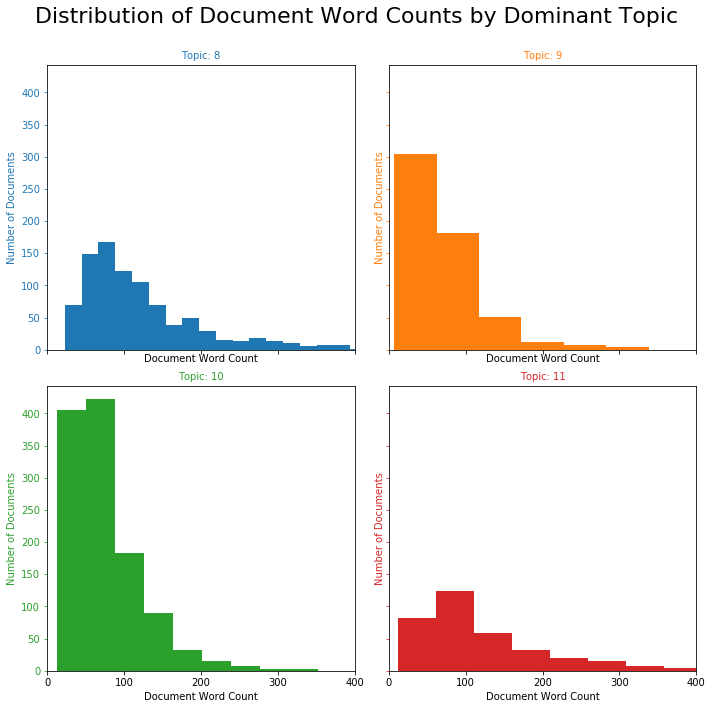

In [0]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(10,10),  sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i+8, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    #sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 400), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i+8), fontdict=dict(size=10, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,400,5))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

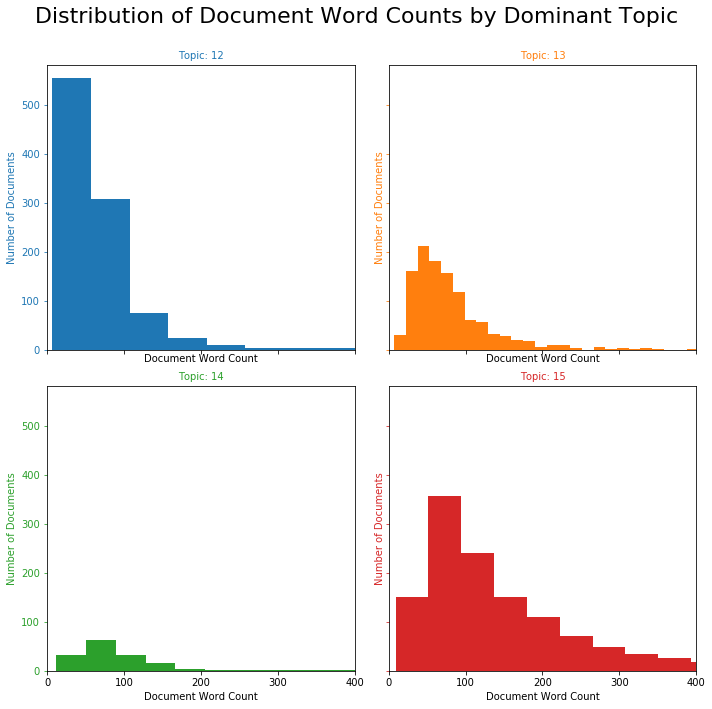

In [0]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(10,10),  sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i+12, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    #sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 400), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i+12), fontdict=dict(size=10, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,400,5))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

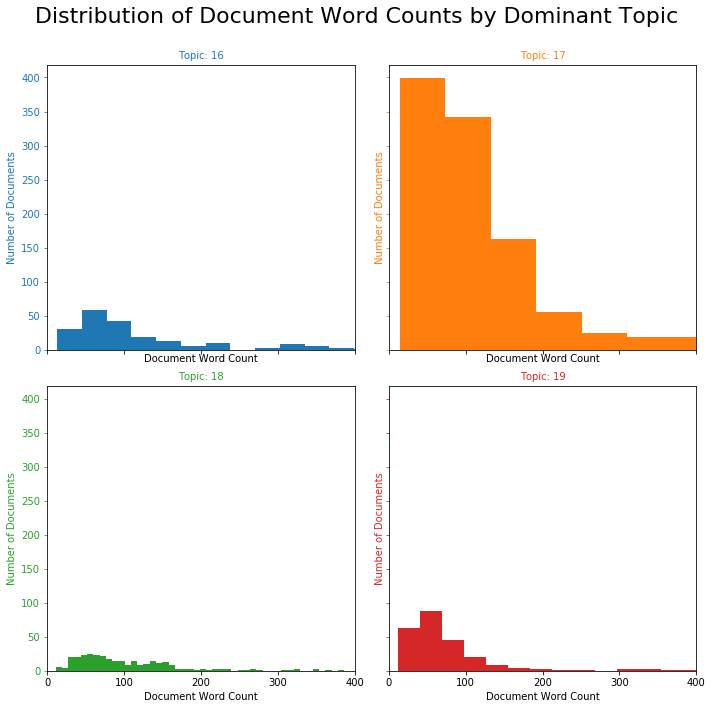

In [0]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(10,10),  sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i +16, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    #sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 400), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i +16), fontdict=dict(size=10, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,400,5))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

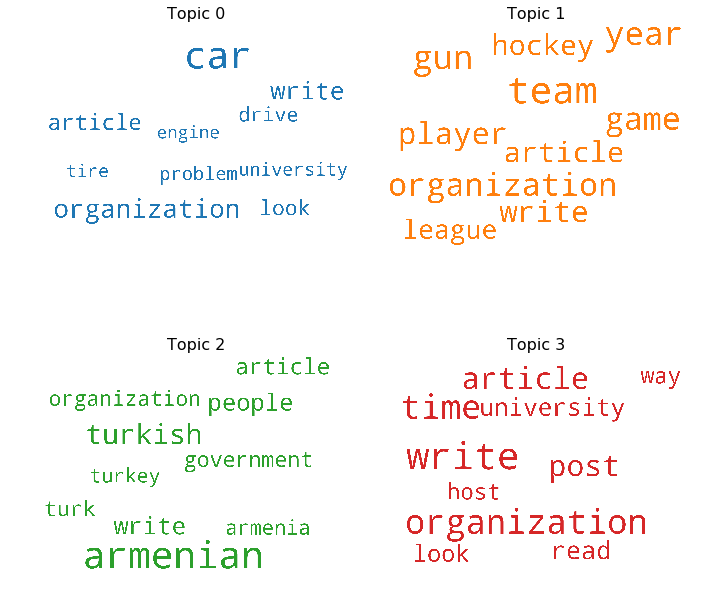

In [0]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

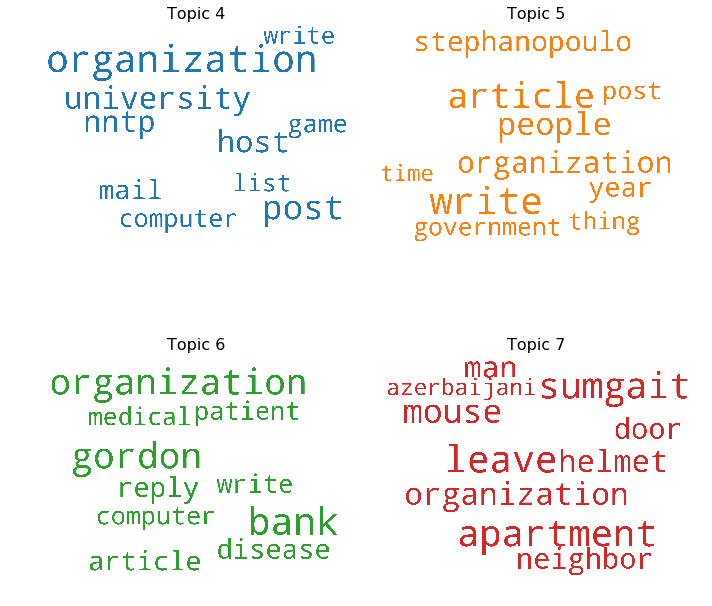

In [0]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i+4][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+4), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()